<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/Inicio_PINN_MEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

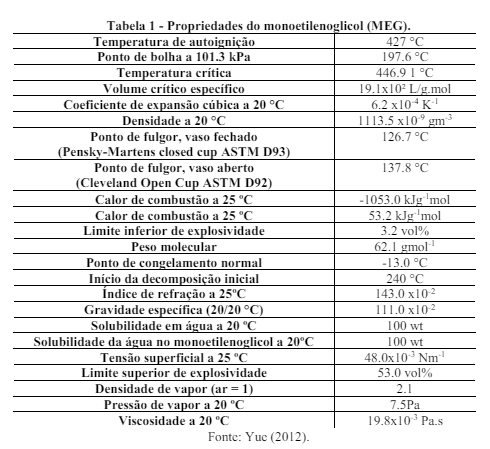

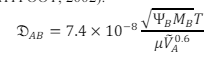

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from tensorflow.keras.layers import Input, Dense
from time import time
from tensorflow.keras.optimizers import Adam
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import display, Image, HTML
from sklearn.preprocessing import MinMaxScaler

keras.backend.set_floatx('float32')
tf.random.set_seed(0)
np.random.seed(0)
k = 1

In [2]:
#Definindo os pontos X
N_0 = 200 #200 pontos para condição inicial
N_bx = 200 #200 pontos para condição de contorno em x
N_by = 200 #200 pontos para a condição de contorno em y
N_r = 20000 #Pontos para a edp

#Pontos do domínio
tmin = 0. ; tmax = 1. #Tempo de simulação
xmin = 0.; xmax = 1 #largura do duto
ymin = 0.; ymax = 10. #Diametro


#Constantes
T = 352.89 #K
v = 2.21 #m/s
psimeg = 2.6 #parametro do solvente
Mmeg = 1.98+2*5.48 #Peso molecular do meg, em g/mol
mi = 0.891 #Viscosidade da solução, centipoises
Va = 55.7582 #Volume molar do soluto, em cm³/g*mol
Difu = 7.4e-8 *((np.sqrt(psimeg*Mmeg)*T)/(mi*Va**0.6))
lb = tf.constant([tmin, xmin, ymin]); ub = tf.constant([tmax, xmax, ymax])

In [9]:
#Agora criando o modelo de Rede neural

def modelopinn(nos, camadas_ocultas):
  modelo = Sequential()
  #Inserindo o numero de variaveis de entrada
  modelo.add(Input(shape = (3,)))
  #Escala de entrada, mapeando os pontos de maximo e minimo
  modelo.add(keras.layers.Lambda(
      lambda x: 2.0*(x - lb)/(ub - lb) - 1.0
  ))
  for i in range(camadas_ocultas):
        modelo.add(Dense(nos, activation='tanh', kernel_initializer=GlorotNormal())) #camada oculta

  modelo.add(Dense(1)) #camada de saída
  modelo.summary()
  return modelo

In [10]:
modelo = modelopinn(20,8)

otimizador = Adam(learning_rate = 0.001)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 20)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,041 (11.88 KB)

 Trainable params: 3,041 (11.88 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def c_contorno(t, x, y):
  return tf.where(tf.equal(x, tf.reduce_max(x)), 1.0 * tf.ones_like(x), tf.zeros_like(x))
  #return tf.ones_like(x)

def c_inicial(x, y):
  return tf.zeros_like(x)

#Ponto inferior e superior, respectivamente
lb = tf.constant([tmin, xmin, ymin]); ub = tf.constant([tmax, xmax, ymax])

#Obtendo pontos para a condição inicial
t0 = tf.zeros((N_0,1))*lb[0]
x0 = tf.random.uniform((N_0,1), lb[1], ub[1]) #Colocando os valores de x0 em ordem aleatoria, indo de 0 a 2
y0 = tf.random.uniform((N_0, 1), lb[2], ub[2])
espaco0 = tf.concat([t0, x0, y0], 1) #Criando uma matriz com os valores de tempo = 0 e de x0
#Condição inicial
c0 = c_inicial(x0,y0)

#Repetindo o processo, mas para a condição de contorno
tbx = tf.random.uniform((N_by,1), lb[0], ub[0])
xbx = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_by,1), 0.5)
ybx = tf.random.uniform((N_by,1), lb[2], ub[2])
espacobx = tf.concat([tbx, xbx, ybx], 1)
c_contx = c_contorno(tbx,xbx,ybx)

tby1 = tf.random.uniform((N_by,1), lb[0], ub[0])
xby1 = tf.random.uniform((N_by,1), lb[1], ub[1])
yby1 = tf.zeros((N_bx,1))
espacoby1 = tf.concat([tby1, xby1, yby1], 1)

tby2 = tf.random.uniform((N_by,1), lb[0], ub[0])
xby2 = tf.random.uniform((N_by,1), lb[1], ub[1])
yby2 = tf.ones((N_bx,1))*ub[2]
espacoby2 = tf.concat([tby2, xby2, yby2], 1)
#Repetindo o processo, mas agora é para obter os pontos da EDP
tr = tf.random.uniform((N_r,1), lb[0], ub[0])
xr = tf.random.uniform((N_r,1), lb[1], ub[1])
yr = tf.random.uniform((N_r,1), lb[2], ub[2])
espacor = tf.concat([tr, xr,yr], 1)

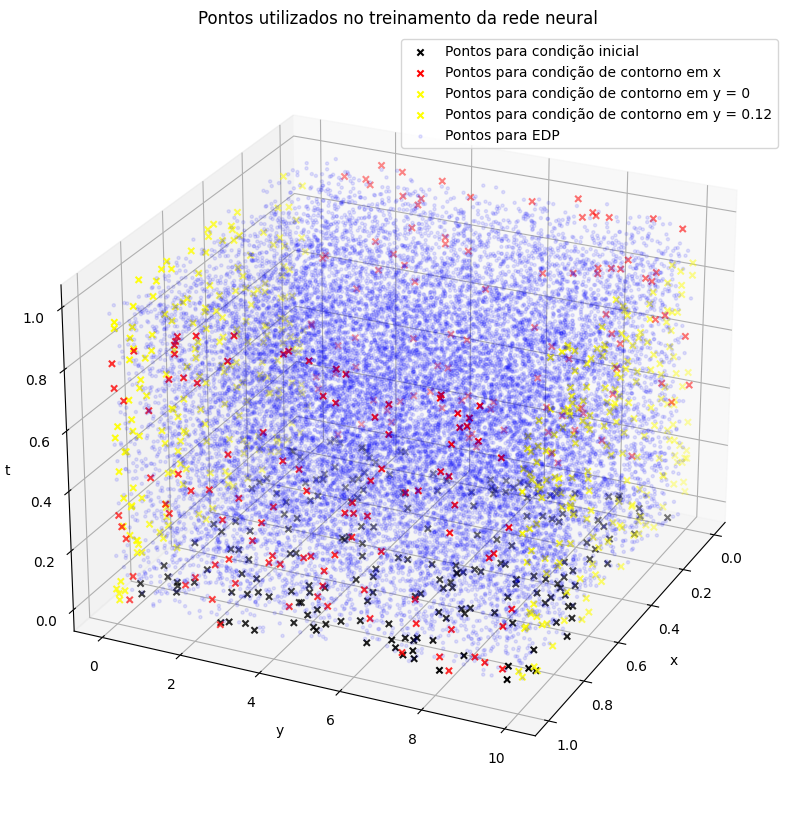

In [12]:
# Plotar os pontos que serão utilizados
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x0,y0,t0, c = 'black', marker ='x', label = 'Pontos para condição inicial')
ax.scatter(xbx,ybx,tbx, c = 'red', marker = 'x', label = 'Pontos para condição de contorno em x')
ax.scatter(xby1,yby1,tby1, c = 'yellow', marker = 'x', label = 'Pontos para condição de contorno em y = 0')
ax.scatter(xby2,yby2,tby2, c = 'yellow', marker = 'x', label = 'Pontos para condição de contorno em y = 0.12')
ax.scatter(xr,yr,tr, c = 'blue', marker = '.', alpha = 0.1, label = 'Pontos para EDP')
ax.view_init(25,25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
ax.legend()
ax.set_title('Pontos utilizados no treinamento da rede neural');
plt.show()

In [13]:
#E tirando os gradientes, para calcular a edp
def gradiente(modelo, X_r):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    t, x, y = X_r[:, 0:1], X_r[:,1:2], X_r[:,2:3]
    tape.watch(t)
    tape.watch(x)
    tape.watch(y)

    #previsão do modelo
    u = modelo(tf.concat([t, x, y], axis = 1))

    #Derivadas de primeira ordem
    u_x = tape.gradient(u, x)
    u_y = tape.gradient(u, y)
    u_t = tape.gradient(u,t )

    #Derivadas de segunda ordem
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)
    #f = u_t + v*(u_x + u_y) + Difu*(u_xx + u_yy)
    f = u_t + v*(u_x + u_y)
  del tape

  return f
'''

def neumanncondy2(modelo, espacoby2):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    ty2, xy2, yy2 = espacoby2[:, 0:1], espacoby2[:,1:2], espacoby2[:,2:3]
    tape.watch(ty2)
    tape.watch(xy2)
    tape.watch(yy2)
    #previsão do modelo
    u = modelo(tf.concat([ty2, xy2, yy2], axis = 1))
    u_y = tape.gradient(u, yy2)

    return u_y
'''
def neumanncondy1(modelo, espacoby1):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    ty1, xy1, yy1 = espacoby1[:, 0:1], espacoby1[:,1:2], espacoby1[:,2:3]
    tape.watch(ty1)
    tape.watch(xy1)
    tape.watch(yy1)
    #previsão do modelo
    u = modelo(tf.concat([ty1, xy1, yy1], axis = 1))
    u_y = tape.gradient(u, yy1)

    return u_y

def MSE(modelo, xr, espaco0, c0, espacobx, c_cont, espacoby1, espacoby2):

    #Erro edp
    f = gradiente(modelo, xr)
    erro_c = tf.reduce_mean(tf.square(f))
    #erro_c = tf.reduce_mean(tf.square(g))

    loss = erro_c

    u0 = modelo(espaco0)
    with tf.GradientTape(persistent=True) as tape:
      #Registrando tempo e posição para a diferenciação automática
      tx1, xx1, yx1 = espacobx[:, 0:1], espacobx[:,1:2], espacobx[:,2:3]
      tape.watch(tx1)
      tape.watch(xx1)
      tape.watch(yx1)
      #previsão do modelo
      u_x = modelo(tf.concat([tx1, xx1, yx1], axis = 1))

    u_y1 = neumanncondy1(modelo, espacoby1)
    u_y2 = neumanncondy1(modelo, espacoby2)

    loss += tf.reduce_mean(tf.square(u_y1))
    loss += tf.reduce_mean(tf.square(u_y2))
    loss += tf.reduce_mean(tf.square(c_cont - u_x))
    loss += tf.reduce_mean(tf.square(c0 - u0))

    return erro_c, loss

def grad(modelo, xr, espaco0, c0, espacobx, c_cont, espacoby1, espacoby2):
  #tirando o gradiente em relação ao modelos, para que eles sejam atualizados posteriormente
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(modelo.trainable_variables)
    erro_c, loss = MSE(modelo, xr, espaco0, c0, espacobx, c_cont, espacoby1, espacoby2)

  g = tape.gradient(loss, modelo.trainable_variables)
  del tape

  return erro_c, loss, g

In [14]:
#etapa de treinamento como uma função do TensorFlow para aumentar a velocidade do treinamento
@tf.function
def train_step(modelo):
  #Calculando a perda do modelo em relação ao modelo, com a função grad
  erro_c, loss, grad_theta = grad(modelo, espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2)

  #Aplicando o gradiente as variaveis do modelo de rede neural
  otimizador.apply_gradients(zip(grad_theta, modelo.trainable_variables))

  return erro_c, loss

itr = 2000
historico = []
erro_aux_p = []
erro_aux_c = []
t0 = time()

for i in range(itr+1):

    erro_c, loss = train_step(modelo)

    #Salvando os erros para listar
    historico.append(loss.numpy())
    #erro_aux_p.append(erro_p.numpy())
    erro_aux_c.append(erro_c.numpy())


    if i%100 == 0:
        print(i,"Loss treino: {:10.8e}, Loss edp f: {:10.8e}, ".format(loss, erro_c))

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

ValueError: in user code:

    File "<ipython-input-8-d175803c6ea3>", line 5, in train_step  *
        erro_c, loss, grad_theta = grad(modelo, espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2)
    File "<ipython-input-7-72545c48b143>", line 89, in grad  *
        tape.watch(modelo.trainable_variables)

    ValueError: Passed in object <KerasVariable shape=(3, 20), dtype=float32, path=sequential_1/dense_9/kernel> of type 'Variable', not tf.Tensor or tf.Variable or ExtensionType.


In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(range(len(historico)), historico, 'k-', label='Custo total')
#ax.plot(range(len(erro_aux_p)), erro_aux_p, 'b-', label='Custo da EDP para p')
ax.plot(range(len(erro_aux_c)), erro_aux_c, 'r-', label='Custo da EDP para c')
ax.set_yscale('log')
ax.set_xlabel('itr')
ax.set_ylabel('Loss');
ax.legend()
plt.show()

In [ ]:
N = 200
xspace = np.linspace(lb[1], ub[1], N + 1)
yspace = np.linspace(lb[2], ub[2], N + 1)

#em t = 0.1
t_01 = 100.
T, X, Y = np.meshgrid(t_01, xspace, yspace)
X01 = np.vstack([T.flatten(),X.flatten(), Y.flatten()]).T
u = modelo(X01)
U_01 =  u.numpy().reshape(1, N+1, N+1)

#em t = 0.5s
t_05 = 300.
T, X, Y = np.meshgrid(t_05, xspace, yspace)
X05 = np.vstack([T.flatten(),X.flatten(), Y.flatten()]).T
u_05 = modelo(X05)
U_05 = u_05.numpy().reshape(1, N+1, N+1)

#em t=1s
t_1 = 598.
T,X,Y = np.meshgrid(t_1, xspace, yspace)
X1 = np.vstack([T.flatten(), X.flatten(), Y.flatten()]).T
u_1 = modelo(X1)
U_1 = u_1.numpy().reshape(1, N+1, N+1)

Xaux, Yaux = np.meshgrid(xspace, yspace)

In [ ]:
fig  = plt.figure(figsize = (20, 18))
# snapshot 1
ax   = fig.add_subplot(3, 3, 1, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, U_01[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('p(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para p = p(t,x,y) em t = 0.1')

ax   = fig.add_subplot(3, 3, 2, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, U_05[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 0.1')
# snapshot 2
ax   = fig.add_subplot(1, 3, 1, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, U_1[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 0.5')

# snapshot 3
ax   = fig.add_subplot(1, 3, 2, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, c_1[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 1')

In [ ]:
tspace = np.linspace(lb[0], ub[0], N + 1)
Tt, Xt, Yt = np.meshgrid(tspace, xspace, yspace)
Xgrid = np.vstack([Tt.flatten(),Xt.flatten(), Yt.flatten()]).T

#Realizando predição
upred = modelo(Xgrid)

In [ ]:
U = upred.numpy().reshape(N+1,N+1,N+1)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

def frame(w):
    ax.clear()

    plt.title("Função de transporte no instante: {:1.4} s".format(tspace[w]))
    ax.set_xlabel('x(t)')
    #ax.set_xlim3d(0,1)
    ax.set_ylabel('y(t)')
    #ax.set_ylim3d(0,1)
    ax.set_zlabel('c(t,x,y)'.format(tspace[w]))
    #ax.set_zlim3d(-val1,val1)

    plot=ax.plot_surface(Yaux, Xaux, U[w], cmap='jet')


    return plot


anim = animation.FuncAnimation(fig, frame, frames=200, blit=False, repeat=True)

anim.save('Função Transporte PINN.gif', writer = "pillow", fps=10 )
HTML(anim.to_html5_video())

In [ ]:
#Plotagem da pinn
def plotheatmap2d(u_k, k):

    plt.clf()
    plt.imshow(u_k, cmap='jet',
              extent=[xspace[0], xspace[-1], yspace[0], yspace[-1]],
              origin='lower', aspect='auto', vmin = 0.0, vmax = 1.0)


    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('c(t,x,y) em diferentes instantes de tempo - PINNs')
    plt.colorbar()
    return plt

def anima(k):
    plotheatmap2d(U[k], k)

animacao = animation.FuncAnimation(plt.figure(), anima, interval=1, frames=100, repeat=False)
animacao.save("testepinn.gif")

display(Image(filename="testepinn.gif"))

In [ ]:
class PINN_Arquitetura(keras.Model):

    def __init__(self, lb, ub,
            saida=1,
            camadas_ocultas=8,
            nos_ocultos=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.camadas_ocultas = camadas_ocultas
        self.saida = saida
        self.lb = lb
        self.ub = ub


        self.scale = keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [Dense(nos_ocultos,
                             activation=keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.camadas_ocultas)]
        self.out = Dense(saida)

    def call(self, X):

        Z = self.scale(X)
        for i in range(self.camadas_ocultas):
            Z = self.hidden[i](Z)
        return self.out(Z)

In [ ]:
modelo = PINN_Arquitetura(lb, ub)
modelo.build(input_shape = (None, 3))
modelo.summary()

In [ ]:
class PINN():
    def __init__(self, modelo, espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2):
        self.modelo = modelo

        #pontos de colocação da edp
        self.t = espacor[:,0:1]
        self.x = espacor[:,1:2]
        self.y = espacor[:,2:3]
        self.t0 = espaco0[:,0:1]; self.x0 = espaco0[:,1:2]; self.y0 = espaco0[:,2:3]
        self.tx1 = espacobx[:,0:1]; self.xx1 = espacobx[:,1:2]; self.yx1 = espacobx[:,2:3]
        self.ty1 = espacoby1[:,0:1]; self.xy1 = espacoby1[:,1:2]; self.yy1 = espacoby1[:,2:3]
        self.ty2 = espacoby2[:,0:1]; self.xy2 = espacoby2[:,1:2]; self.yy2 = espacoby2[:,2:3]

        self.espacobx = espacobx
        self.espacoby1 = espacoby1
        self.espacoby2 = espacoby2

        self.c0 = c0
        self.c_contx1 = c_contx

        #histórico de perdas e o contador global de iterações
        self.hist = []
        self.hist_c = []
        self.iter = 0

    def gradiente(self):
      #Registrando tempo e posição para a diferenciação automática

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(self.t)
            tape.watch(self.x)
            tape.watch(self.y)

            #previsão do modelo
            u = self.modelo(tf.concat([self.t, self.x, self.y], axis = 1))
            u_t = tape.gradient(u, self.t)

            u_x = tape.gradient(u, self.x)
            u_xx = tape.gradient(u_x, self.x)

            u_y = tape.gradient(u, self.y)
            u_yy = tape.gradient(u_y, self.y)

            #edo para função de transporte
            #g = tape.gradient(c,self.t) + tape.gradient(f*c, self.x) + tape.gradient(f*c , self.y)
            f = u_t + v*(u_x + u_y) - Difu*(u_xx + u_yy)

        del tape

        return f

    def neumanncondy1(self):
      with tf.GradientTape(persistent=True) as tape:
        tape.watch(self.ty1)
        tape.watch(self.xy1)
        tape.watch(self.yy1)

        uy1 = self.modelo(tf.concat([self.ty1, self.xy1, self.yy1], axis = 1))

        c_y = tape.gradient(uy1, self.yy1)

        return c_y


    def neumanncondy2(self):
      with tf.GradientTape(persistent=True) as tape:
        tape.watch(self.ty2)
        tape.watch(self.xy2)
        tape.watch(self.yy2)

        uy2 = self.modelo(tf.concat([self.ty2, self.xy2, self.yy2], axis = 1))

        c_y = tape.gradient(uy2, self.yy2)

        return c_y


    def MSE(self, espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2):
      #Erro edp
        f = self.gradiente()
        erro_c = tf.reduce_mean(tf.square(f))

        loss = erro_c
        #Erro da rede neural
        u0 = self.modelo(espaco0)
        ux1 = self.modelo(espacobx)
        c_y1 = self.neumanncondy1()
        c_y2 = self.neumanncondy2()

        loss += tf.reduce_mean(tf.square(c_contx - ux1)) + tf.reduce_mean(tf.square(c0 - u0))
        loss += tf.reduce_mean(tf.square(c_y2)) + tf.reduce_mean(tf.square(c_y1))

        return erro_c, loss

    def grad(self, espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2):
      #tirando o gradiente em relação ao modelos, para que eles sejam atualizados posteriormente
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.modelo.trainable_variables)
            erro_c, loss = self.MSE(espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2)

        g = tape.gradient(loss, self.modelo.trainable_variables)
        del tape

        return erro_c, loss, g


    def treino(self, espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2, method='L-BFGS-B', **kwargs):

        def get_weight_tensor():
            #Função para retornar variáveis atuais do modelo como tensor 1d, bem como formas correspondentes como listas.

            weight_list = []
            shape_list = []

            #loop sobre todas as variáveis, ou seja, matrizes de peso + bias e parâmetros desconhecidos
            for v in self.modelo.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            #Função que define lista de pesos para variáveis do modelo.
            idx = 0
            for v in self.modelo.variables:
                vs = v.shape

                #Matriz do peso
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                #Vetor bias
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                #Variáveis (no caso de configuração de identificação de parâmetro)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                #Atribuir variáveis (cast necessário, pois o scipy requer o tipo float64)
                v.assign(tf.cast(new_val, 'float32'))

        def get_loss_and_grad(w):
            #Função que fornece perda de custo e gradiente em relação às variáveis ​​treináveis ​​como vetor.

            #Atualizar os pesos
            set_weight_tensor(w)
            #Determinar o custo da rede neural
            erro_c, loss, grad = self.grad(espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2)

            #Armazenando o custo atual para a função de retorno
            loss = loss.numpy().astype(np.float64)
            erro_c = erro_c.numpy().astype(np.float64)
            self.current_loss = loss
            self.current_erro_c = erro_c

            #Salvando os valores do gradiente
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            #Convertendo para array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            #Retornando o custo e o gradiente
            return loss, grad_flat

        #retorno, minimizando o gradiente
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: Loss = {:10.8e}, Loss edp f = {:10.8e}'.format(self.iter,self.current_loss, self.current_erro_c))
        self.hist.append(self.current_loss)
        self.hist_c.append(self.current_erro_c)
        self.iter+=1

    def plot_loss_history(self, ax= None):
        if not ax:
            fig = plt.figure(figsize=(9,6))
            ax = fig.add_subplot(111)
        ax.plot(range(len(self.hist)), self.hist, 'k-', label = 'Custo total')
        ax.plot(range(len(self.hist_c)), self.hist_c, 'r-', label  = 'Custo associado a EDP')
        ax.set_yscale('log')
        ax.set_xlabel('itr')
        ax.set_ylabel('Loss')
        ax.legend()
        return ax

In [ ]:
modelo_pinn = PINN(modelo, espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2)

t0 = time()
modelo_pinn.treino(espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2,
                            method='L-BFGS-B',
                            options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

In [ ]:
modelo_pinn.plot_loss_history();

In [ ]:
tspace = np.linspace(lb[0], ub[0], N + 1)
Tt, Xt, Yt = np.meshgrid(tspace, xspace, yspace)
Xgrid = np.vstack([Tt.flatten(),Xt.flatten(), Yt.flatten()]).T

#Realizando predição
upred = modelo(Xgrid)

In [ ]:
U = upred.numpy().reshape(N+1,N+1,N+1)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

def frame(w):
    ax.clear()

    plt.title("Função de transporte no instante: {:1.4} s".format(tspace[w]))
    ax.set_xlabel('x(t)')
    #ax.set_xlim3d(0,1)
    ax.set_ylabel('y(t)')
    #ax.set_ylim3d(0,1)
    ax.set_zlabel('c(t,x,y)'.format(tspace[w]))
    #ax.set_zlim3d(-val1,val1)

    plot=ax.plot_surface(Yaux, Xaux, U[w], cmap='jet')


    return plot


anim = animation.FuncAnimation(fig, frame, frames=200, blit=False, repeat=True)

anim.save('Função Transporte PINN.gif', writer = "pillow", fps=10 )
HTML(anim.to_html5_video())